In [ ]:
# default_exp core

# core

> Primary functions for using `pyspice` to simulate the 3-MOSFET circuit known as a Chaogate.

In [ ]:
#hide
from nbdev import *
from nbdev.imports import *
from nbdev.export import *
from nbdev.sync import *
from nbdev.showdoc import *

In [ ]:
#hide
%load_ext autoreload
%autoreload 2

# imports

In [ ]:
#exports
import warnings
with warnings.catch_warnings(): #ignore warnings
    warnings.simplefilter("ignore")
    
    import copy
    import os
    import matplotlib.pyplot as plt
    import numpy as np
    import gzip
    import numba
    from numba import njit
    import sidis
    import xarray as xr

    import PySpice.Logging.Logging as Logging
    from PySpice.Doc.ExampleTools import find_libraries
    from PySpice.Spice.Library import SpiceLibrary
    from PySpice.Spice.Netlist import Circuit
    from PySpice.Unit import *
    
    import nptyping
    from nptyping import NDArray as Array
    from nptyping import get_type,Int,Float
    import typing
    from typing import (Optional, Tuple, Dict, Callable, 
                        Union, Mapping, Sequence, Iterable, 
                        Hashable, List, Any)
    
    from tqdm import tqdm

In [ ]:
#hide
#import codecs
#codecs.register(lambda name: codecs.lookup('utf-8') if name == 'u25ba' else None)

First, we must specify a global path to our `pyspice` library:

In [ ]:
#exports
global_path = r'C:\Anaconda3\Lib\site-packages\PySpice\Examples\libraries\chaogate'

We will use this to construct the `chaogate`:

# netlist

In [ ]:
#export
def chaogate(path : str = global_path,
             Vdd : float = 1.2,
             Vin : Optional[float] = 0.45,
             Vbias : float = 0.45,
             w1 = 120e-9,
             w2 = 120e-9,
             w3 = 2000e-9,
             l1 = 65e-9,
             l2 = 65e-9,
             l3 = 65e-9,
             capacitance : int = 1e-15,
             noise : Optional[float] = 0,
             noise_type : str = 'gaussian',
             noise_duration : int = 1e-9,
             noise_delay : int = 0,
             time_delay : int = 1e-9,
             impedance : int = 50,
             TEMP = None
            ):
    '''
    Constructs PySpice circuit object for a chaogate.
    
    Parameters:
    
        `path` : location of folder containing following spice files 
               '65nm_bulk.lib','bsim4.out','bsim4v5.out','nmos.mod','pmos.mod'
               
        `vdd` : static positive terminal voltage in Volts. 
            If `noise` is not 0 or None, a random source of `noise_type` 
            fluctuating about `vdd` with amplitude `noise` is used to 
            represent the supply voltage, with fluctuation lasting 
            `noise_duration` ever `noise_delay` seconds.
            
        `vin` : static input voltage in Volts. 
            If vin=0 or None, it is replaced with a transmission line having 
            the `time_delay` and `impedance` args that connects `vin` to `vout`.
            
        `vbias` : bias voltage in Volts. This changes the MOSFET behavior.
        
        `widths` : MOSFET widths of the three transistors in Meters
        
        `lengths` : MOSFET lengths of the three transistors in Meters
        
        `capacitance` : capacitor constant in Farads
    '''
    
    #setup circuit, library, logger
    circuit=Circuit('Three MOSFET Chaogate')
    circuit.logger = Logging.setup_logging()
    circuit.spice_library = SpiceLibrary(path)
    circuit.include(circuit.spice_library['nmos'])
    circuit.include(circuit.spice_library['pmos'])
    
    #give unchanging circuit elements
    #convention is <node name>, <positive node name>, <negative node name>, <optional voltage>
    circuit.C('load', 'vout', 'vss', u_F(capacitance))
    circuit.V('ss', 'vss', circuit.gnd, u_V(0))
    circuit.V('bias', 'vbias', circuit.gnd,u_V(Vbias))
    
    if not noise: #implement zero noise on source
        circuit.V('dd','vdd', circuit.gnd, u_V(Vdd))
    else: #implement random variation of source voltage
        circuit.RandomVoltageSource('dd','vdd', circuit.gnd,
                                    random_type='gaussian',
                                    duration=noise_duration,
                                    time_delay=noise_delay,
                                    parameter1=noise,
                                    parameter2=Vdd)
    
    #if vin is not 0 or None, it is a static voltage source
    if Vin: 
        circuit.V('in', 'vin', circuit.gnd, u_V(Vin))
    else: #else, we connect vin to vout with a transmission line
        circuit.LosslessTransmissionLine('delay', 'vin', circuit.gnd, 'vout', circuit.gnd,
                impedance = impedance, 
                time_delay = time_delay)
    
    #give mosfet elements
    circuit.MOSFET(1, 'vout', 'vin', 'vss', 'vss', model='nmos',
                l=l1, w=w1) 
    circuit.MOSFET(2, 'vout', 'vbias', 'vdd', 'vdd', model='pmos',
                l=l2, w=w2)
    circuit.MOSFET(3, 'vdd', 'vin', 'vout', 'vss', model='nmos',
                l=l3, w=w3)
    
    return circuit

In [ ]:
#export
def tup2ar(*t):
    '''
    Returns inclusive array 'x' of tuple 't' in (start,stop,step) format.
    '''
    s=(t[0],t[1]+t[2],t[2])
    x=np.arange(*s)
    #round to number of decimal places
    x=np.around(x,np.rint(abs(np.log10(t[-1]))).astype(int)+1)
    #cut off anything past bounds
    x=x[x<=t[1]]
    return x

We set `Vin` default parameters as properties of the chaogate function, to preserve memory:

In [ ]:
#exports
chaogate.Vin_tup=(0,1.2,0.01)
chaogate.Vin_ar=tup2ar(*chaogate.Vin_tup)
chaogate.Vin_slice=slice(*chaogate.Vin_tup)

The subsequent dc transfer-function 'sweep' defaults to giving the Vin-Vout transfer curve over Vin=(0,1.2,0.01) by using `tup2ar` on these global parameters:

In [ ]:
tup2ar(0,1.2,0.01)

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  , 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09,
       1.1 , 1.11, 1.12, 1.13, 1.14, 1.15, 1.16, 1.17, 1.18, 1.19, 1.2 ])

# transfer function

In [ ]:
#export
@sidis.timer
def sweep(*funcs,
          **kwargs : Optional[Dict[str,Union[float,tuple]]]
      ) -> Union[Dict[str,Array],Array]:
    '''

    Performs a dc analysis sweep of the input voltage `Vin`, 

    and optionally over any tuples in `kwargs`. If any `kwargs`

    are not tuples, they are treated as circuit parameters for

    instantiation. If any of the `kwargs` tuples are keyed by

    `Vbias`, `Vdd`, or `TEMP`, they are calculated in a single

    sweep using the `simulator().dc` function call. Otherwise,

    the chaogate netlist is repeatedly instantiated over the

    changing parameters, and the simulator repeatedly called. 

    Returns a `DataArray` for each `kwargs` containing `vout`

    dc function call, and coordinates of the sweeped array(s).

    If `funcs` is given, they are mapped over `vout` for each

    sweep, and added as coordinates to the returned `DataArray`.

    '''
    sweep_kwargs = {}
    static_kwargs = {}
    #partition kwargs into sweep vars and static vars
    for k,v in kwargs.items():
        if type(v) is tuple:
            sweep_kwargs[k]=v
        else:
            static_kwargs[k]=v
    #set default temperature
    if static_kwargs.get('TEMP') is not None:
        temp=static_kwargs['TEMP']
    else:
        temp=25
    #set default vin sweep if none given
    if sweep_kwargs.get('Vin') is None:
        Vin_slice=chaogate.Vin_slice
        Vin_ar=chaogate.Vin_ar
    else:
        Vin_tup=sweep_kwargs.pop('Vin')
        Vin_slice=slice(*Vin_tup)
        Vin_ar=tup2ar(*Vin_tup)
    
    if not sweep_kwargs: #only sweep vin
        cg=chaogate(**static_kwargs)
        f=cg.simulator(temperature=temp,nominal_temperature=25).dc
        vout=f(Vin=Vin_slice).vout
        coords=dict(Vin=Vin_ar)
        if funcs: #map functions as coordinates over data
            func_res={f.__name__:f(vout) for f in funcs}
            coords.update(func_res)
        return xr.DataArray(data=vout,
                            dims=['Vin'],
                            coords=coords,
                            name='vout'
                           )

    res=[] #otherwise we have tuples to sweep
    
    for k,s in sweep_kwargs.items():
        if k=='TEMP' or k=='Vbias' or k=='Vdd': #then sweep in 1 call
            cg=chaogate(**static_kwargs)
            f=cg.simulator(temperature=temp,nominal_temperature=25).dc
            vout=f(Vin=Vin_slice,**{k:slice(*s)}).vout
            coord=tup2ar(*s)
            vout=np.array(vout.reshape(( coord.size, Vin_ar.size )))
            res+=[xr.DataArray(data=vout,
                               dims=[k,'Vin'],
                               coords={k:coord,'Vin':Vin_ar},
                               name='vout'
                              )]
        else: #have to re-instantiate circuit and loop over attr
            coord=tup2ar(*s)
            res_k=np.empty((coord.size,Vin_ar.size))
            for i,c in enumerate(coord):
                new_static_kwargs=copy.copy(static_kwargs)
                new_static_kwargs.update({k:c})
                cg=chaogate(**new_static_kwargs)
                f=cg.simulator(temperature=temp,nominal_temperature=25).dc
                vout=f(Vin=Vin_slice).vout
                res_k[i]=np.array(vout)
            res+=[xr.DataArray(data=res_k,
                               dims=[k,'Vin'],
                               coords={k:coord,'Vin':Vin_ar},
                               name='vout'
                              )]

    if funcs: #map functions as coordinates over data
        for vout in res:
            func_res={f.__name__:(vout.dims[0],f(vout.data)) for f in funcs}
            vout.coords.update(func_res)

    if len(res)==1: #if only 1 sweep, just pass back xar
        res=res[0]

    return res

`sweep` returns the Vin-Vout transfer curve as an `xarray.DataArray` object, which contains the useful property of referencing our `coordinates` as well as our `data` as attributes. Unfortunately, there's some unicode errors in it's representation when converting to html, so we'll use the following custom function for clarity:

In [ ]:
#export
def print_xar(x):
    if not isinstance(x,xr.core.dataset.Dataset):
        s=x.to_dataset()
    else:
        s=x
    dim=s.dims
    var=s.data_vars
    def a_1(a):
        try:
            l=len(a//2)
            res=str(np.around(np.ravel(a),4)[:l if l<3 else 3])[:-1]
        except:
            res=str(np.around(a,4))
        return res
    def a_2(a):
        try:
            l=len(a//2)
            res=str(np.around(np.ravel(a),4)[-len(a//2) if len(a//2)<3 else -3:])[1:]
        except:
            res=str(np.around(a,4))
        return res
    data=[f"{s[d].name}: {s[d].shape} : {a_1(s[d])} ... {a_2(s[d])}" for d in var]
    coords=[f"{s[d].name} : {s[d].shape} : {a_1(s[d])} ... {a_2(s[d])}" for d in dim]
    S='Coordinates'+'\n\t'+'\n\t'.join(coords)+'\n'
    S+='Variables'+'\n\t'+'\n\t'.join(data)
    print(S)

In [ ]:
res=sweep(Vin=(0,1.2,0.1))
print_xar(res)

sweep : Elapsed time: 0.0877 seconds
Coordinates
	Vin : (13,) : [0.  0.1 0.2 ... 1.  1.1 1.2]
Variables
	vout: (13,) : [1.1997 1.1987 1.1898 ... 0.5386 0.6035 0.6697]


The traditional `numpy.ndarray` is stored in the `data` attribute:

In [ ]:
print(type(res.data))

<class 'numpy.ndarray'>


Any tupled arg besides Vin results in a 2-D `sweep` of all Vin-Vout values over that arg.

Any non-tupled args are static netlist parameters for each of these transfer curves.

sweep : Elapsed time: 0.0164 seconds


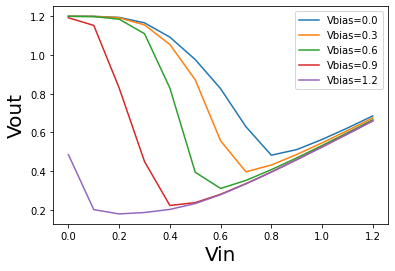

In [ ]:
v=sweep(Vin=(0,1.2,0.1),Vbias=(0,1.2,0.3),TEMP=25)
for vbias in v.Vbias:
    plt.plot(v.Vin.data,v.sel(Vbias=vbias).data,label=f'Vbias={vbias.data}')
    plt.xlabel('Vin',fontsize=20)
    plt.ylabel('Vout',fontsize=20)
    plt.legend()

Multiple tupled args gives a 2-D array for each tuple:

In [ ]:
s=sweep(TEMP=(20,30,5),w1=(60e-9,120e-9,60e-9),Vin=(0,1.2,0.4),l2=120e-9,Vbias=0.9)
for s in s:
    print('\n')
    print_xar(s)

sweep : Elapsed time: 0.0660 seconds


Coordinates
	TEMP : (3,) : [20 25 30 ... 20 25 30]
	Vin : (4,) : [0.  0.4 0.8 ... 0.4 0.8 1.2]
Variables
	vout: (3, 4) : [1.1685 0.2011 0.3945 ... 0.2042 0.3956 0.6589]


Coordinates
	Vin : (4,) : [0.  0.4 0.8 ... 0.4 0.8 1.2]
	w1 : (2,) : [0. 0. ... 0. 0.]
Variables
	vout: (2, 4) : [1.1763 0.2264 ... 0.395  0.6588]


# 1-d maps and chaos

In [ ]:
#export
@sidis.timer
@njit
def iterate_map(vout : Array[(Any, ...)],
                vin : Array[(Any)] = tup2ar(0,1.2,0.01),
                v0 : float = 0.45,
                N : int = 2000) -> Array[(2,...)]:
    '''
    Iterates the map given by `vout` = f(`vin`), `N` times.
    `vout` : [...,size(vin)] is an array of all the
    chaogate output voltages over the `vin` inputs.
    `v0` is the starting voltage. Returns an array
    `X` : [vout.shape[:-1],N,2] containing the 
    map evaluations in the [...,0]th entry and the first 
    derivatives in the [...,1] entry for each curve of `vout`.
    Note, if `vout.shape==vin.shape`, this will return an array
    of shape [1,vin.size,2]. 
    '''
    vo = vout.reshape((int(vout.size/vin.size),vout.shape[-1]))
    J = vo.shape[0]
    X=np.zeros((J,N,2))
    dv=vin[1]-vin[0]
    for j in range(J):
        xn=v0
        for i in range(N):
            X[j,i,0]=xn
            xn=np.interp(x=xn,xp=vin,fp=vo[j])
        X[j,:,1]=np.interp(x=X[j,:,0],xp=vin[:-1],fp=np.diff(vo[j]))/dv
    return X

In [ ]:
#export
def iterate(res,
            v0 : float = 0,
            N : int = None) -> Array[(2,...)]:
    '''
    Uses `iterate_map` with a default iteration number 
    corresponding to the length of the input array `vout`, 
    and reshapes according to this length. njit is unable
    to do this, so we use two functions.
    '''
    if N is None:
        N=res.Vin.shape[-1]
    X = iterate_map(res.data,res.Vin.data,v0,N)
    dims = list(res.dims)
    if len(dims)==1:
        dims = []
    else:
        dims = dims[:-1]
    dims += ['Iterations','Derivative']
    return xr.DataArray(data=X.reshape(*res.shape[:-1],*X.shape[-2:]),
                        dims=dims,
                        coords={k:v for k,v in res.coords.items() if k!='Vin'},
                        name='iterate'
                       )

We iterate the chaogate 1-D map by passing in the transfer function, and then interpolating the equation 
    
V_{n+1} = f(V_{n})
    
where f is the interpolated `Vin-Vout` transfer curve obtained from `sweep`. Similarly, we calculate the derivative `f'` through interpolation in order to later calculate the Lyapunov exponent.

We define two functions, `iterate_map` and `iterate`, for operating on `numpy.ndarray` and `xarray.DataArray` objects respectively. They both do the same thing, but `iterate_map` is accelerated by `njit` and `iterate` uses `iterate_map` to operate directly off of the `sweep` result:

In [ ]:
res=sweep(Vin=(0,1.2,0.001),Vbias=(0,1.2,0.1))
itr_xarray=iterate(res)
itr_numpy=iterate_map(vout=res.data,vin=res.Vin.data,N=res.shape[-1],v0=0)
print(itr_numpy.shape,itr_xarray.shape)

sweep : Elapsed time: 0.2907 seconds


C:\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


iterate_map : Elapsed time: 4.4006 seconds
iterate_map : Elapsed time: 0.0069 seconds
(13, 1201, 2) (13, 1201, 2)


In [ ]:
np.all(itr_numpy==itr_xarray.data)

True

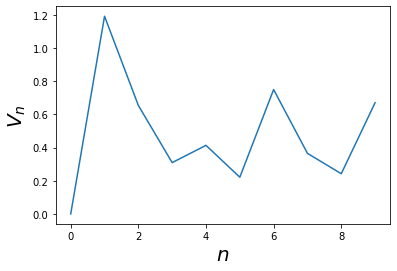

In [ ]:
plt.xlabel(r'$n$',fontsize=20)
plt.ylabel(r'$V_{n}$',fontsize=20)
plt.plot(itr_xarray.sel(Vbias=0.9)[:10,0].data)

How do we know if the system is chaotic? We calculate the `lyapunov` exponent, which for a 1-D map is defined by 

\lambda(x) = \sum_{i=0}^{i=len(x)} |\log(f'(x_{i}))|
   
If \lambda>0, the system is chaotic. In our function definition we assume we have used the `iterate` function to obtain the derivative sequence as the `itr[...,1]` entry, and include some typecasting to parse `xarray.DataArray` objects vs. `numpy.ndarray`s.

In [ ]:
#export
def lyapunov(x : Array[Any,...], replace_zeros_with : Union[int,float] = 0.01):
    '''
    Returns average Lyapunov exponent of array 'x'.
    Replaces zeros with `replace_zeros_with` to 
    calculate log correctly.
    '''
    if isinstance(x,xr.DataArray): #assume iterate map
        y=np.abs(x.data[...,1],dtype=np.float64)
    else:
        y=np.abs(x,dtype=np.float64)
    y[y==0]=replace_zeros_with
    y=np.log(y)
    y=np.mean(y,axis=-1)
    if not isinstance(x,xr.DataArray):
        return y
    else:
        return xr.DataArray(data=y,
                            dims=list(x.dims)[:-2],
                            coords=x.coords,
                            name='lyapunov'
                           )

In [ ]:
lyapunov(itr_numpy[...,1])

array([-0.16071408, -0.07844988, -0.04112648,  0.15231649, -0.07962312,
       -0.57319253, -0.47311614, -0.20360983, -0.24639367,  0.31114034,
       -0.03277629, -0.36456376, -3.87151678])

In [ ]:
print_xar(lyapunov(itr_xarray))

Coordinates
	Vbias : (13,) : [0.  0.1 0.2 ... 1.  1.1 1.2]
Variables
	lyapunov: (13,) : [-0.1607 -0.0784 -0.0411 ... -0.0328 -0.3646 -3.8715]


Now, it will be convenient to calculate a full sweep over a `grid`, i.e, to include every combination of the `sweep` parameters:

# parameter space and bifurcation

In [ ]:
#export
@sidis.timer
def grid(**kwargs):
    '''
    Like 'sweep', but over all combinations of the `kwargs` tuples.
    Returns a `kwargs`-dimensional hybercube ranging over all the
    supplied tuples, in the form of an `xarray.DataArray` object.
    '''
    #partition kwargs into loops and static attrs
    if kwargs.get('Vin') is None:
        Vin = chaogate.Vin_tup
    else:
        Vin = kwargs.get('Vin')
        
    sweep_kwargs = {'Vin':Vin}
    static_kwargs = {}
    for k,v in kwargs.items():
        if type(v) is tuple:
            sweep_kwargs[k]=v
        else:
            static_kwargs[k]=v
    
    #sort loops by giving order of attrs; placing sweeps as inner loops
    key={kwarg:3 for kwarg in kwargs}
    key['Vin']=-1
    key['Vbias']=0
    key['Vdd']=1
    key['TEMP']=2
    #get number of inner loops for callable dc args; iterate over rest
    n_inner_loops = 2 if ('Vbias' in sweep_kwargs or 'Vdd' in sweep_kwargs \
                          or 'TEMP' in sweep_kwargs) else 1
    #print(n_inner_loops)
    sweep_kwargs=list(sweep_kwargs.items())
    sweep_kwargs.sort(key=lambda t:key[t[0]],reverse=True)
    
    #get dict of inner slice for dc function call
    inner_slice={sweep_kwargs[-n_inner_loops][0]:slice(*sweep_kwargs[-n_inner_loops][1])}
    sweep_kwargs=dict(sweep_kwargs)
    
    #get coordinates as dict of arrays for every sweep
    coords={k:tup2ar(*v) for k,v in sweep_kwargs.items()}
    
    #get sizes of array
    sizes=[c.size for c in coords.values()]
    
    #create array holding output of dc function calls over grid of coords
    arr=np.zeros(tuple(sizes))
    
    #truncate coords up to inner value for function calls
    static_arg_list=list(coords.items())[:-n_inner_loops]
    
    #loop over ndindex of outer loops, call inner as sweep
    #use tqdm as progress bar, give total length of outer loop
    for s in np.ndindex(arr.shape[:-n_inner_loops]):#tqdm(np.ndindex(arr.shape[:-n_inner_loops]), 
                  #total=np.prod(arr.shape[:-n_inner_loops])):
        
        #index static args and feed to chaogate netlist
        static_args={k:v[s[i]] for i,(k,v) in enumerate(static_arg_list)}
        circuit=chaogate(**static_args)
        
        #get temperature of current sweep
        if static_args.get('TEMP') is None:
            temp=25
        else:
            temp=static_args.get('TEMP')
            
        #perform sweep, feed to array
        f=circuit.simulator(temperature=temp,nominal_temperature=25).dc
        vout=f(Vin=slice(*Vin),**inner_slice).vout
        arr[s]=np.array(vout.reshape(( arr.shape[-2], arr.shape[-1] )))
    
    #return as xar object containing coords and any func calls
    res=xr.DataArray(data=arr,dims=list(coords),coords=coords,name='vout')
    
    return res

`grid` sweeps over all combinations of the input parameters:

In [ ]:
g = grid(Vin=(0,1.2,0.01),Vbias=(0,1.2,0.01),Vdd=(1.15,1.25,0.01))

grid : Elapsed time: 2.3441 seconds


In [ ]:
print_xar(g)

Coordinates
	Vbias : (121,) : [0.   0.01 0.02 ... 1.18 1.19 1.2 ]
	Vdd : (11,) : [1.15 1.16 1.17 ... 1.23 1.24 1.25]
	Vin : (121,) : [0.   0.01 0.02 ... 1.18 1.19 1.2 ]
Variables
	vout: (11, 121, 121) : [1.1499 1.1499 1.1498 ... 0.6505 0.6573 0.6642]


Next, we will convert the grid to a `xarray.Dataset` object in order to add fields for the `iterate` and `lyapunov` data over the full parameter space. We do this through a simple conversion and dictionary update:

In [ ]:
ds=g.to_dataset()
print_xar(ds)

Coordinates
	Vbias : (121,) : [0.   0.01 0.02 ... 1.18 1.19 1.2 ]
	Vdd : (11,) : [1.15 1.16 1.17 ... 1.23 1.24 1.25]
	Vin : (121,) : [0.   0.01 0.02 ... 1.18 1.19 1.2 ]
Variables
	vout: (11, 121, 121) : [1.1499 1.1499 1.1498 ... 0.6505 0.6573 0.6642]


We must specify the dimensions over which the new data are to be added. We calculate the iteration with 2000 points, and discard the first 500 as a transient. Then, we parse the original dimensions to remove the last entry (`Vin`) as we don't use this in the calculation. We also add a new dimension for the iterations:

In [ ]:
itr=iterate(g,N=2000)
lya=lyapunov(itr[...,500:,:])
ds.update(dict(lyapunov=(list(g.dims)[:-1],lya),
              iterate=(list(g.dims)[:-1]+['Iterations'],itr[...,500:,0])
              ))
print_xar(ds)

iterate_map : Elapsed time: 1.8145 seconds
Coordinates
	Iterations : (1500,) : [0 1 2 ... 1497 1498 1499]
	Vbias : (121,) : [0.   0.01 0.02 ... 1.18 1.19 1.2 ]
	Vdd : (11,) : [1.15 1.16 1.17 ... 1.23 1.24 1.25]
	Vin : (121,) : [0.   0.01 0.02 ... 1.18 1.19 1.2 ]
Variables
	vout: (11, 121, 121) : [1.1499 1.1499 1.1498 ... 0.6505 0.6573 0.6642]
	lyapunov: (11, 121) : [-0.1492 -0.1409 -0.1326 ... -1.2073 -1.4748 -1.765 ]
	iterate: (11, 121, 1500) : [0.5076 0.915  0.5076 ... 0.1909 0.1909 0.1909]


Now, we can easily extract the maximum lyapunov exponent in parameter space by using the `argmax` and `isel` methods.

In [ ]:
lmax=ds.isel(ds.lyapunov.argmax(...)) #(...) means all dimensions; could do e.g ['Vbias'] for variation over Vdd
print(lmax.lyapunov.data,lmax.Vdd.data,lmax.Vbias.data)

0.3579636171223563 1.16 0.43


We see the greatest lyapunov exponent is at `Vdd=1.16, Vbias=0.43`. Of course, we can extract the same information using the data itself and numpy, it's just more clunky and requires us to backtrack to find the coordinate indices...

In [ ]:
ds.lyapunov.data[np.unravel_index(np.argmax(ds.lyapunov.data),ds.lyapunov.data.shape)]

0.3579636171223563

Now, we package this functionality (calculating `iterate` and `lyapunov`) into a pipeline `bifurcate`:

In [ ]:
#export
def bifurcate(res=None,
              v0=0,
              T=500,
              N=1000,
              as_grid=False,
              **kwargs):
    '''
    Creates a bifurcation of the system about the given parameters.

    If `as_grid`, the result is assumed to be evaluated over a grid; 
    
    else, a `sweep` is assumed. If `res` is None, it is evaluated over
    
    `kwargs`. Iterates the resulting system `res` N times starting from 
    
    `v0` using `iterate`, discarding the transient specified by the first 
    
    `T` points. Calculates the `lyapunov` exponent over the iterated map, 
    
    and returns a `xarray.Dataset`. If not `as_grid`, the dataset has
    
    a different variable for each of the specified `kwargs` sweeps; else,
    
    there is a single variable for `vout`, `lyapunov`, and `iterate`.

    Example use: 

        bifurcate(
            Vbias = (0,1.2,0.01),
            Vdd = (1.1,1.3,0.1),
            TEMP = (20,30,5),
            as_grid = True
        )

    '''
    if not as_grid:
        if res is None: 
            res=sweep(**kwargs)
    
        if not isinstance(res,list): 
            res=[res]
        coords={'Vin':res[0].Vin}
        coords.update({r.dims[0]:r.coords[r.dims[0]] for r in res})
        ds=xr.Dataset(data_vars={'vout_'+r.dims[0]:(r.dims,r) for r in res},
                     coords=coords)
        for k,v in ds.data_vars.items():
            itr=iterate(v,N=N,v0=v0)
            lya=lyapunov(itr[...,T:,:])
            ds.update({
                'iterate_'+k[5:]:([v.dims[0],'Iterations'],itr[...,0]),
                'lyapunov_'+k[5:]:(v.dims[0],lya)
            })
    else:
        if res is None:
            res=grid(**kwargs)
        ds=res.to_dataset()
        itr=iterate(res,N=N,v0=v0)
        lya=lyapunov(itr[...,T:,:])
        ds.update(dict(lyapunov=(list(res.dims)[:-1],lya),
                       iterate=(list(res.dims)[:-1]+['Iterations'],itr[...,0])
                      )
                 )

    return ds

In [ ]:
b=bifurcate(Vbias=(0,1.2,0.01))
print_xar(b)

sweep : Elapsed time: 0.2609 seconds
iterate_map : Elapsed time: 0.0689 seconds
Coordinates
	Iterations : (1000,) : [0 1 2 ... 997 998 999]
	Vbias : (121,) : [0.   0.01 0.02 ... 1.18 1.19 1.2 ]
	Vin : (121,) : [0.   0.01 0.02 ... 1.18 1.19 1.2 ]
Variables
	vout_Vbias: (121, 121) : [1.1998 1.1998 1.1998 ... 0.6457 0.6525 0.6593]
	iterate_Vbias: (121, 1000) : [0.     1.1998 0.6851 ... 0.1792 0.1792 0.1792]
	lyapunov_Vbias: (121,) : [-0.146  -0.1378 -0.1295 ... -2.9459 -3.5419 -4.5371]


We can visualize bifurcation as the expansion or contraction of the system's state-space as a parameter is varied. We visualize this by plotting the set of iterations on the Y-axis, and the system parameter on the X-axis, with chaotic points in red

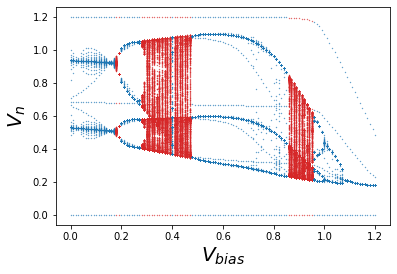

In [ ]:
xaxis = b.Vbias.data
yvalues = b.iterate_Vbias.data
lyapunovs = b.lyapunov_Vbias.data

for i,(x,y) in enumerate(zip(xaxis, yvalues)): # (x,[set of y]) pairs
    color='tab:red' if lyapunovs[i]>0 else 'tab:blue' #red if chaotic
    plt.scatter([x] * len(y), y, s=.1, color=color)
plt.xlabel(r'$V_{bias}$',fontsize=20)
plt.ylabel(r'$V_{n}$',fontsize=20)
plt.show()

Next we will evaluate these properties over an entire grid and test the computational stability of the chaogate.

In [ ]:
ds=bifurcate(Vbias=(0,1.2,0.01),Vdd=(1.15,1.25,0.001),as_grid=True)
print_xar(ds)

grid : Elapsed time: 28.1231 seconds
iterate_map : Elapsed time: 5.2643 seconds
Coordinates
	Iterations : (1000,) : [0 1 2 ... 997 998 999]
	Vbias : (121,) : [0.   0.01 0.02 ... 1.18 1.19 1.2 ]
	Vdd : (101,) : [1.15  1.151 1.152 ... 1.248 1.249 1.25 ]
	Vin : (121,) : [0.   0.01 0.02 ... 1.18 1.19 1.2 ]
Variables
	vout: (101, 121, 121) : [1.1499 1.1499 1.1498 ... 0.6505 0.6573 0.6642]
	lyapunov: (101, 121) : [-0.1492 -0.1409 -0.1326 ... -1.2073 -1.4748 -1.765 ]
	iterate: (101, 121, 1000) : [0.     1.1499 0.6456 ... 0.1909 0.1909 0.1909]


Now, let's examine the Hamming distances for the iterated maps. We will use this to gauge the stability of the system for computation; if one of the parameters varies, we don't want the bitstream to diverge, or it can't be used for stable logic

# booleanization and computational stability

In [ ]:
#export
@njit
def booleanize_ar(vn, threshold=None):
    '''
    Convert the numpy array `vn` into a bitstream
    according to `threshold`; values of `vn>=threshold`
    will be set to `1`, and values of `vn<threshold`
    will be set to `0`. If `threshold` is not supplied,
    it defaults to halfway between the range of `vn`.
    '''
    if threshold is None:
        threshold=(np.max(vn)-np.min(vn))/2
    B=np.empty(vn.shape)
    for s in np.ndindex(vn.shape):
        if vn[s]>=threshold:
            B[s]=1
        else:
            B[s]=0
    return B

In [ ]:
#export
def booleanize(vn, threshold=None):
    '''
    Like `booleanize_ar`, but with typecasting
    for `xarray.DataArray` inputs.
    '''
    if isinstance(vn,xr.DataArray):
        B=booleanize_ar(vn.data,threshold)
        return vn.copy(deep=False,data=B)
    else:
        return booleanize_ar(vn,threshold)

The output of the analog system must be `booleanize`d in order to produce a bitstream, or sequence of 0s and 1s. This is done by rounding about some threshold.

In [ ]:
booleanize(np.array([0,0.5,1,0.7,0.2]),threshold=0.5)

array([0., 1., 1., 1., 0.])

In [ ]:
booleanize(np.array([0,0.5,0.2,0.25]),threshold=None) #defaults to (max=0.5 - min=0)/2

array([0., 1., 0., 1.])

In [ ]:
#export
def boolean_gradient(vn , threshold=None, dimensions_up_to=-1):
    '''
    Compute the `booleanize`d gradient of the 
    iterated map `vn`. 
    '''
    B = booleanize(vn,threshold)
    axes = tuple([i for i,s in enumerate(B.shape[:dimensions_up_to])])
    grad = np.gradient(B,axis=axes)
    if not isinstance(grad,list):
        grad = list(grad)
    grad = np.array(grad)
    return grad

In [ ]:
grad = boolean_gradient(ds.iterate)

In [ ]:
grad.shape

(2, 101, 121, 1000)

The first entry in grad is the matrix derivative along each direction; here, along Vdd and Vcc.
The rest mimics the shape of the original input.

In [ ]:
#export
def boolean_divergence(grad , N=-1, normalize=False):
    '''
    Compute the divergence of the absolute value of the 
    `boolean_gradient` `grad` after `N` iterations.
    If `normalize`, divide the result by the max.
    '''
    #first get hamming distances over iterations
    div = np.mean(np.abs(grad[...,:N]),axis=-1)
    #now average over each matrix derivative direction
    div = np.mean(div,axis=0)
    if normalize:
        div /=np.max(div)
    return div

In [ ]:
div = boolean_divergence(grad)

In [ ]:
div.shape

(101, 121)

The divergence has the shape of the parameter axes, as it averaged over the iterations.

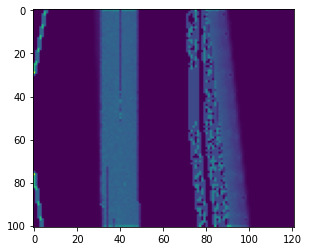

In [ ]:
plt.imshow(div)
#plt.colorbar()

The x-axis is Vcc, and the y-axis is Vdd. 

Now let's compare the divergence to the chaotic regions, where the Lyapunov exponent >0

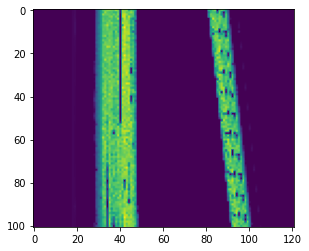

In [ ]:
plt.imshow((ds.lyapunov.data>0)*ds.lyapunov.data)
#plt.colorbar()

We see they have similar structure. For chaotic logic, we are interested in minimizing their overlap; we want the divergence to be minimal (small logic error), and the lyapunov exponent to be positive (chaos). To that end we can take a normalized linear combination, weighting the divergence by -1 and the lyapunov exponent by +1

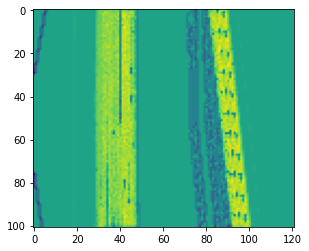

In [ ]:
normalized_lyapunov = (ds.lyapunov.data>0)*ds.lyapunov.data/np.max(ds.lyapunov.data)
normalized_divergence = div/np.max(div) 
optimizer = normalized_lyapunov - normalized_divergence 
plt.imshow(optimizer)
#plt.colorbar()

We can now use this as an optimization metric in our future efforts to create the "best" chaogate

In [ ]:
sidis.refresh()